<a href="https://colab.research.google.com/github/leonardoacosta91/PrediccionPreciosApartamentosMercadoLibre/blob/main/PrediccionVentaApartamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importaciones

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from numpy import arange

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline

In [ ]:
raw_apartamentos = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Prediccion precios Apartamentos/ventaApartamentosMeLi.csv', sep = ';', decimal= ',')

## Funciones de visualizacion de datos

In [ ]:
def barPlot(dataframe,title,xColumn,xLabel,yColumn,yLabel):
  plt.figure(figsize=(14,6))
  ax = sns.barplot(x=xColumn,y=yColumn,data=dataframe,palette="Blues_d")
  ax.axes.set_title(title,fontsize=20)
  ax.set_xlabel(xLabel,fontsize=15)
  ax.set_ylabel(yLabel,fontsize=15)
  ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
  for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

def linePlot(dataframe,title,xColumn,xLabel,yColumn,yLabel,optional_hue="none"):
  plt.figure(figsize=(14,6))
  if optional_hue is not "none":
    ax = sns.lineplot(data=dataframe,x=xColumn,y=yColumn,hue=optional_hue)
  else:
    ax = sns.lineplot(data=dataframe,x=xColumn,y=yColumn)
  ax.axes.set_title(title,fontsize=20)
  ax.set_xlabel(xLabel,fontsize=15)
  ax.set_ylabel(yLabel,fontsize=15)

def pieChart(dataframe,title,size,labels):
  plt.figure(figsize=(18,10))
  plt.pie(x=dataframe[size],autopct="%.1f%%",labels=dataframe[labels],pctdistance=0.5)
  plt.title(title,fontsize=20)
  plt.show()

def scatterPlot(dataframe,title,xColumn,xLabel,yColumn,yLabel,linea=False):
  plt.figure(figsize=(14,6))
  if linea:
    ax = sns.regplot(data = dataframe, x = xColumn, y = yColumn)
  else:
    ax = sns.scatterplot(data = dataframe, x = xColumn, y = yColumn)
  ax.axes.set_title(title,fontsize=15)
  ax.set_xlabel(xLabel,fontsize=10)
  ax.set_ylabel(yLabel,fontsize=10)

def histPlot(dataframe,xColumn,bins=15):
  plt.figure(figsize=(14,6))
  ax = sns.displot(data=dataframe,x=xColumn, bins=bins,kde=True)

## Data Wrangling

In [ ]:
raw_apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   link                         718 non-null    object 
 1   titulo                       718 non-null    object 
 2   moneda                       718 non-null    object 
 3   precio                       718 non-null    object 
 4   descripcion                  718 non-null    object 
 5   ubicacion                    718 non-null    object 
 6   condicion                    718 non-null    object 
 7   Superficie total             694 non-null    object 
 8   Superficie cubierta          676 non-null    object 
 9   Dormitorios                  636 non-null    float64
 10  Baños                        660 non-null    float64
 11  Cantidad de pisos            257 non-null    float64
 12  Apartamentos por piso        112 non-null    float64
 13  Número de piso de la

In [ ]:
raw_apartamentos.isnull().sum()

link                             0
titulo                           0
moneda                           0
precio                           0
descripcion                      0
ubicacion                        0
condicion                        0
Superficie total                24
Superficie cubierta             42
Dormitorios                     82
Baños                           58
Cantidad de pisos              461
Apartamentos por piso          606
Número de piso de la unidad    597
Disposición                    541
Antigüedad                     357
Gastos comunes                 494
caracteristicas_ambientes      283
Cocheras                       416
Ambientes                      521
Orientación                    509
Tipo de departamento           682
Bodegas                        702
Acceso                         709
Tipo de cochera                717
Tipo de cobertura              717
Metros de frente               716
Metros de fondo                716
Forma del terreno   

### Precio

In [ ]:
#Visualizo las monedas
raw_apartamentos.moneda.value_counts()

U$S    705
$       13
Name: moneda, dtype: int64

In [ ]:
raw_apartamentos[raw_apartamentos.moneda == '$'].precio

3      158.000
27      63.000
171    250.000
196     88.400
207     79.000
211     65.000
254     69.000
398     95.000
562     10.900
610      9.450
614          1
648      9.450
669    105.000
Name: precio, dtype: object

Cambio todos los precios a dolares porque dudo de que alguno de ellos sea en pesos

In [ ]:
raw_apartamentos.moneda = 'U$S'

In [ ]:
raw_apartamentos['precio'] = raw_apartamentos['precio'].str.replace('.','').astype(float)

<Figure size 1008x432 with 0 Axes>

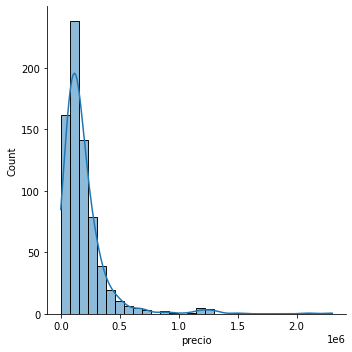

In [ ]:
histPlot(raw_apartamentos,"precio",30)

Se puede observar que su distribucion es bastante atipica, lo que implica existencia de outliers

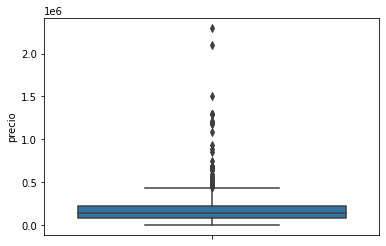

In [ ]:
sns.boxplot(y=raw_apartamentos['precio'])

Claramente existen varios outliers

In [ ]:
raw_apartamentos = raw_apartamentos[raw_apartamentos['precio'] > 1000]

In [ ]:
Q1 = raw_apartamentos['precio'].quantile(0.25)
Q3 = raw_apartamentos['precio'].quantile(0.75)
IQR = Q3 - Q1


raw_apartamentosPrecioLimpio = raw_apartamentos[~((raw_apartamentos['precio'] < (Q1 - 1.5 * IQR)) |(raw_apartamentos['precio'] > (Q3 + 1.5 * IQR)))]

<Figure size 1008x432 with 0 Axes>

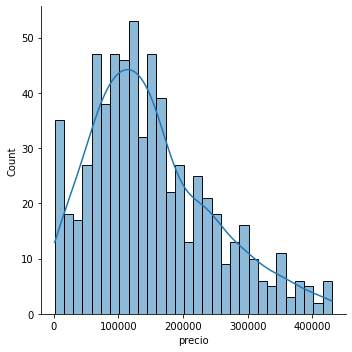

In [ ]:
histPlot(raw_apartamentosPrecioLimpio,"precio",30)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Prediccion precios Apartamentos/Imagenes/precios.png',bbox_inches='tight')

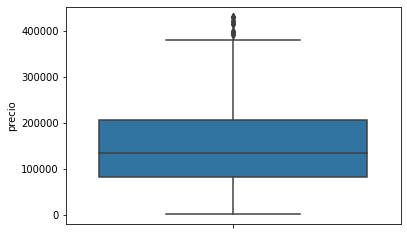

In [ ]:
sns.boxplot(y=raw_apartamentosPrecioLimpio['precio'])

### Ubicacion

In [ ]:
raw_apartamentosPrecioLimpio.ubicacion = raw_apartamentosPrecioLimpio.ubicacion.str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8').apply(lambda row: row.rsplit(',', 1)[0].replace(","," "))

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


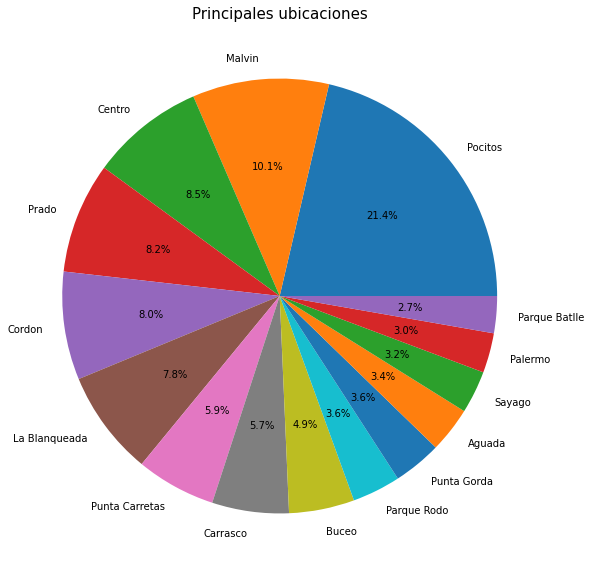

In [ ]:
Listadoubicaciones = raw_apartamentosPrecioLimpio.ubicacion.value_counts().reset_index(name="Ubicacion")[:15].rename(columns={'index': 'ubicacion','Ubicacion':'cantidad'})

plt.figure(figsize=(20,10))
plt.pie(Listadoubicaciones['cantidad'],labels=Listadoubicaciones['ubicacion'],autopct='%1.1f%%')
plt.title('Principales ubicaciones',fontsize=15)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Prediccion precios Apartamentos/Imagenes/ubicaciones.png',bbox_inches='tight')
plt.show()

### Condicion

In [ ]:
raw_apartamentosPrecioLimpio.condicion.value_counts()

Vende    664
Name: condicion, dtype: int64

Como todos comparten el mismo valor elimino la columna

In [ ]:
raw_apartamentosSinCondicion = raw_apartamentosPrecioLimpio.drop("condicion",axis=1)

### Superficie total

Contiene valores nulos, se propone utilizar la columna de superficie cubierta ya que tiene alta correlacion

In [ ]:
raw_apartamentosSinCondicion['Superficie total'] = raw_apartamentosSinCondicion["Superficie total"].fillna(raw_apartamentosSinCondicion['Superficie cubierta'])

In [ ]:
raw_apartamentosSinCondicion['Superficie total'].isnull().sum()

19

Sigo manteniendo la misma cantidad de nulos, por lo que se procede a eliminar los registros sin superficie total, ya que no tengo referencias a utilizar

In [ ]:
raw_apartamentosLimpiezaSupTotal = raw_apartamentosSinCondicion.dropna(subset=["Superficie total"])
print(raw_apartamentosSinCondicion.shape)
print(raw_apartamentosLimpiezaSupTotal.shape)

raw_apartamentosLimpiezaSupTotal['Superficie total'] = raw_apartamentosLimpiezaSupTotal['Superficie total'].str.extract('(\d+)').astype(int)

(664, 30)
(645, 30)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<Figure size 1008x432 with 0 Axes>

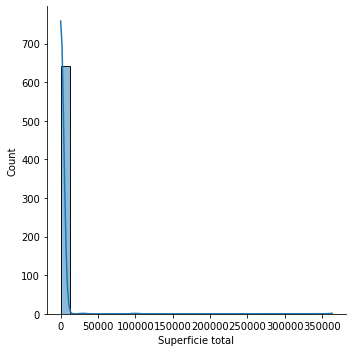

In [ ]:
histPlot(raw_apartamentosLimpiezaSupTotal,"Superficie total",30)

La columna presenta outliers

In [ ]:
raw_apartamentosLimpiezaSupTotal = raw_apartamentosLimpiezaSupTotal[raw_apartamentosLimpiezaSupTotal['Superficie total'] > 9]

In [ ]:
Q1 = raw_apartamentosLimpiezaSupTotal['Superficie total'].quantile(0.25)
Q3 = raw_apartamentosLimpiezaSupTotal['Superficie total'].quantile(0.75)
IQR = Q3 - Q1

raw_apartamentosSupNoOutliers = raw_apartamentosLimpiezaSupTotal[~((raw_apartamentosLimpiezaSupTotal['Superficie total'] < (Q1 - 1.5 * IQR)) |(raw_apartamentosLimpiezaSupTotal['Superficie total'] > (Q3 + 1.5 * IQR)))]

<Figure size 1008x432 with 0 Axes>

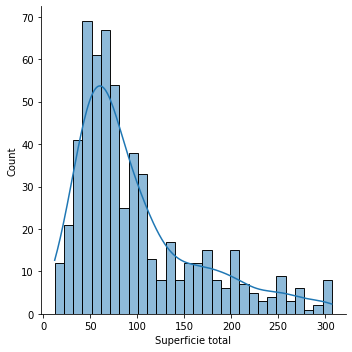

In [ ]:
histPlot(raw_apartamentosSupNoOutliers,"Superficie total",30)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Prediccion precios Apartamentos/Imagenes/Superficie.png',bbox_inches='tight')

Ahora se puede ver una mejor distrubucion de los datos

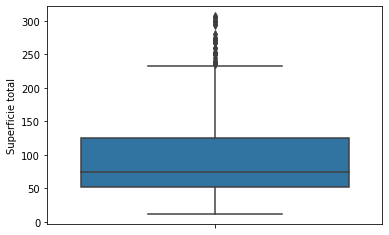

In [ ]:
sns.boxplot(y=raw_apartamentosSupNoOutliers['Superficie total'])

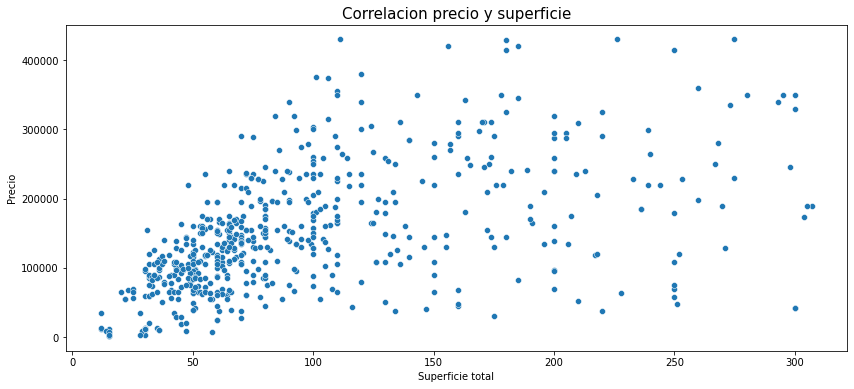

In [ ]:
scatterPlot(raw_apartamentosSupNoOutliers,"Correlacion precio y superficie","Superficie total","Superficie total","precio","Precio")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Prediccion precios Apartamentos/Imagenes/CorrPrecioSup.png',bbox_inches='tight')

### Superficie Cubierta

In [ ]:
raw_apartamentosSupNoOutliers['Superficie cubierta'] = raw_apartamentosSupNoOutliers['Superficie cubierta'].fillna(raw_apartamentosSupNoOutliers['Superficie total'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
raw_apartamentosSupNoOutliers['Superficie cubierta'].isnull().sum()

0

In [ ]:
#raw_apartamentosSupNoOutliers['Superficie cubierta'] = raw_apartamentosSupNoOutliers['Superficie cubierta'].str.extract('(\d+)').astype(int)

In [ ]:
raw_apartamentoSinSupCubierta = raw_apartamentosSupNoOutliers.drop('Superficie cubierta',axis=1)

Elimino la columna ya que tiene una alta correlacion con superficie total

### Dormitorios

In [ ]:
#Reemplazo de dormitorios 
raw_apartamentoSinSupCubierta.Dormitorios = raw_apartamentoSinSupCubierta.Dormitorios.fillna(1)

<Figure size 1008x432 with 0 Axes>

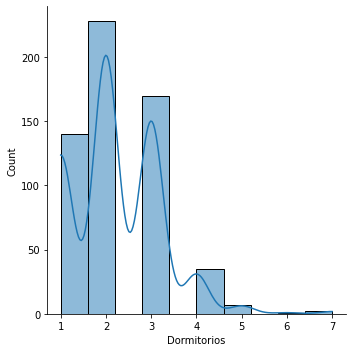

In [ ]:
histPlot(raw_apartamentoSinSupCubierta,"Dormitorios",10)

### Baños

<Figure size 1008x432 with 0 Axes>

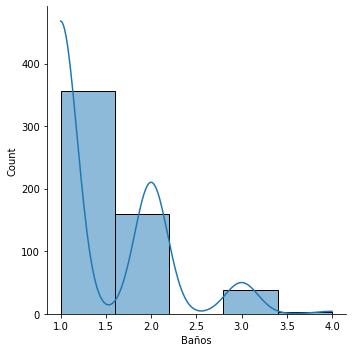

In [ ]:
histPlot(raw_apartamentoSinSupCubierta,"Baños",5)

In [ ]:
raw_apartamentoSinSupCubierta.Baños.isnull().sum()

26

In [ ]:
raw_apartamentoSinSupCubierta.Baños = raw_apartamentoSinSupCubierta.Baños.fillna(1)

### Cantidad de pisos

In [ ]:
raw_apartamentoSinSupCubierta['Cantidad de pisos'].isnull().sum()

368

<Figure size 1008x432 with 0 Axes>

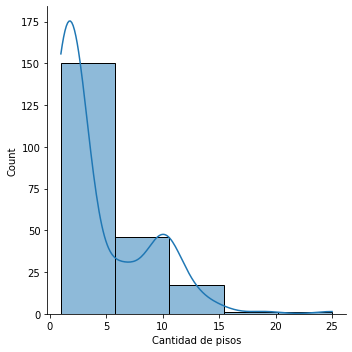

In [ ]:
histPlot(raw_apartamentoSinSupCubierta,"Cantidad de pisos",5)

In [ ]:
raw_apartamentoSinCantPisos = raw_apartamentoSinSupCubierta.drop('Cantidad de pisos',axis=1)

### Cocheras

In [ ]:
raw_apartamentoSinCantPisos.Cocheras = raw_apartamentoSinCantPisos.Cocheras.fillna(0) 

In [ ]:
raw_apartamentoSinCantPisos.Cocheras.value_counts()

0.0    369
1.0    172
2.0     38
3.0      4
Name: Cocheras, dtype: int64

### Antiguedad

In [ ]:
raw_apartamentoSinCantPisos['Antigüedad'] = raw_apartamentoSinCantPisos['Antigüedad'].fillna("0 años")
raw_apartamentoSinCantPisos['Antigüedad'] = raw_apartamentoSinCantPisos['Antigüedad'].str.extract('(\d+)').astype(int)

In [ ]:
raw_apartamentoSinCantPisos['Antigüedad'] = raw_apartamentoSinCantPisos['Antigüedad'].apply(lambda row: row if row < 500 else 2021-row)

Paso la antiguedad de fecha a años

<Figure size 1008x432 with 0 Axes>

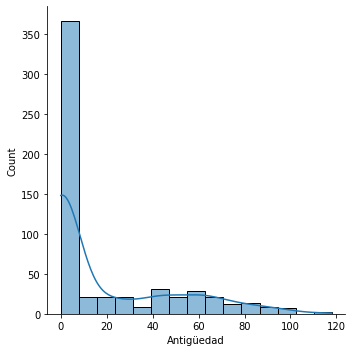

In [ ]:
histPlot(raw_apartamentoSinCantPisos,"Antigüedad",15)

### Gastos Comunes

In [ ]:
raw_apartamentoSinCantPisos['Gastos comunes'] = raw_apartamentoSinCantPisos['Gastos comunes'].fillna("0")
raw_apartamentoSinCantPisos['Gastos comunes'] = raw_apartamentoSinCantPisos['Gastos comunes'].str.extract('(\d+)').astype(int)

In [ ]:
raw_apartamentoSinCantPisos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 717
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   link                         583 non-null    object 
 1   titulo                       583 non-null    object 
 2   moneda                       583 non-null    object 
 3   precio                       583 non-null    float64
 4   descripcion                  583 non-null    object 
 5   ubicacion                    583 non-null    object 
 6   Superficie total             583 non-null    int64  
 7   Dormitorios                  583 non-null    float64
 8   Baños                        583 non-null    float64
 9   Apartamentos por piso        107 non-null    float64
 10  Número de piso de la unidad  114 non-null    float64
 11  Disposición                  168 non-null    object 
 12  Antigüedad                   583 non-null    int64  
 13  Gastos comunes      

### Ubicacion

In [ ]:
dummy_ubicacion = pd.get_dummies(raw_apartamentoSinCantPisos.ubicacion, prefix='ubicacion',drop_first=False) 
dfSinUbicacion = raw_apartamentoSinCantPisos.drop('ubicacion',axis=1) 
raw_apartamentosHotUbicacion = pd.concat([dfSinUbicacion,dummy_ubicacion],axis=1) 

Genero OneHot de Ubicacion

### Otras caracteristicas

In [ ]:
raw_apartamentosHotUbicacion.shape

(583, 82)

In [ ]:
raw_apartamentosHotUbicacion.isnull().sum()

link                        0
titulo                      0
moneda                      0
precio                      0
descripcion                 0
                           ..
ubicacion_Sayago            0
ubicacion_Tres Cruces       0
ubicacion_Union             0
ubicacion_Villa Biarritz    0
ubicacion_Villa Garcia      0
Length: 82, dtype: int64

In [ ]:
ApartamentosLimpio = raw_apartamentosHotUbicacion.drop(['Apartamentos por piso','Número de piso de la unidad','Disposición','Ambientes','Orientación','Tipo de departamento','Bodegas','Acceso',    'Tipo de cochera', 'Tipo de cobertura', 'Metros de frente',
       'Metros de fondo', 'Forma del terreno', 'Disposición del lote','Tipo de casa'],axis=1)

Elimino el resto de features que no son utiles para el modelo

## Correlacion

In [ ]:
ApartamentosLimpio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 717
Data columns (total 67 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   link                           583 non-null    object 
 1   titulo                         583 non-null    object 
 2   moneda                         583 non-null    object 
 3   precio                         583 non-null    float64
 4   descripcion                    583 non-null    object 
 5   Superficie total               583 non-null    int64  
 6   Dormitorios                    583 non-null    float64
 7   Baños                          583 non-null    float64
 8   Antigüedad                     583 non-null    int64  
 9   Gastos comunes                 583 non-null    int64  
 10  caracteristicas_ambientes      367 non-null    object 
 11  Cocheras                       583 non-null    float64
 12  ubicacion_Aguada               583 non-null    uin

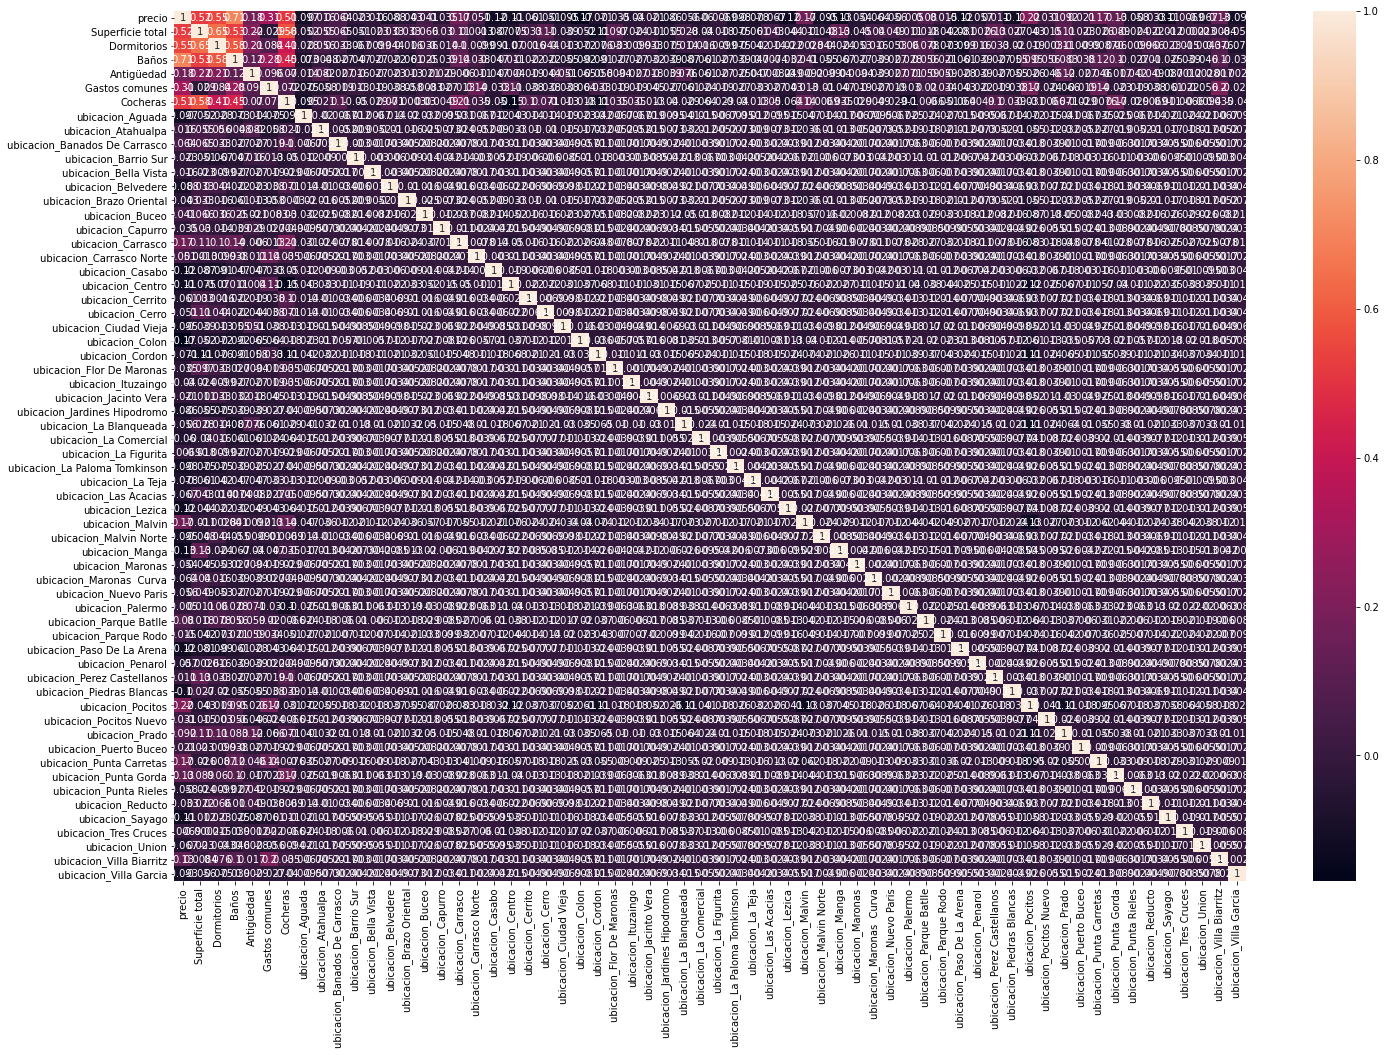

In [ ]:
corr_df = ApartamentosLimpio.corr(method='pearson')

plt.figure(figsize=(24, 16))
sns.heatmap(corr_df, annot=True)
plt.show()

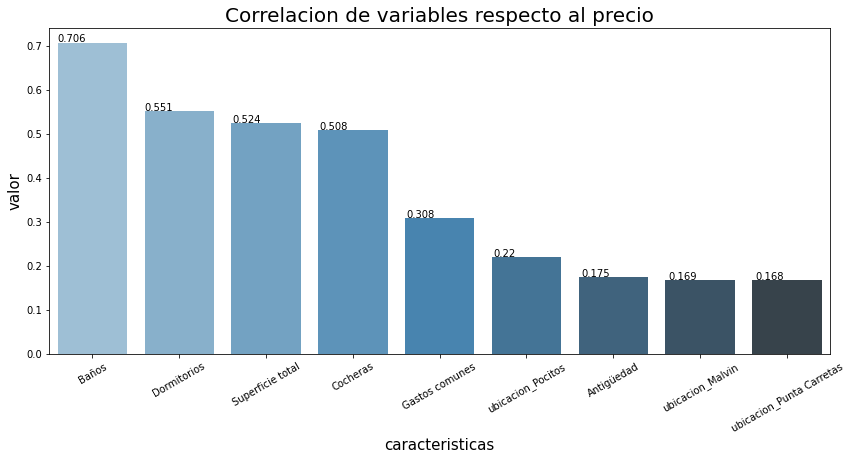

In [ ]:
correlacion = corr_df['precio'].round(decimals=3).abs().sort_values(ascending=False).reset_index()[1:10]

barPlot(correlacion,"Correlacion de variables respecto al precio","index","caracteristicas","precio","valor")
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Prediccion precios Apartamentos/Imagenes/CorrCaracteristicas.png',bbox_inches='tight')

## Machine Learning

In [ ]:
numeric_columns = ApartamentosLimpio.select_dtypes('number').columns
ApartamentosML = ApartamentosLimpio[numeric_columns]

In [ ]:
X = ApartamentosML.drop("precio",axis=1)
y = ApartamentosML['precio']

Genero la division entre los datos y la columna a predecir

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

Genero la division entre los datos de entrenamiento y test

In [ ]:
model_result = []

### Random Forest

In [ ]:
steps = [('scaler', StandardScaler()),
         ('random_forest', RandomForestRegressor())]

pipeline_rf = Pipeline(steps)

In [ ]:
grid_params_rf= {'random_forest__bootstrap': [True, False],
              "random_forest__n_estimators": [20,25,30,50,75],
              'random_forest__max_depth' : [2,5,10,20,30],
              "random_forest__max_features" : ["auto", "sqrt"],
              'random_forest__min_samples_leaf': [1,2,4,6],
              'random_forest__min_samples_split': [2,5,10]}

In [ ]:
random_forest_grid = RandomizedSearchCV(estimator=pipeline_rf,param_distributions=grid_params_rf,n_iter=600,cv=5,verbose=2,random_state=42,n_jobs=-1)

In [ ]:
random_forest_grid.fit(X_train,y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 666 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 1232 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1962 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2852 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:  3.0min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('random_forest',
                                              RandomForestRegressor(bootstrap=True,
                                                                    ccp_alpha=0.0,
                                                                    criterion='mse',
                                                                    max_depth=None,
                                                                    max_features='auto',
                                                                    max_leaf_nodes=None,
                                               

In [ ]:
predictions_RF = random_forest_grid.predict(X_test)

In [ ]:
forest_score = r2_score(y_test, predictions_RF)
model_result.append(['Random Forest',forest_score])

print(forest_score)

0.6858538162654089


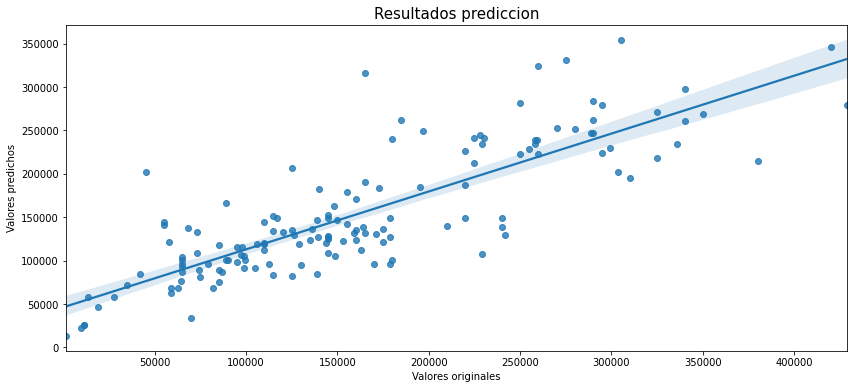

In [ ]:
results_rf_df = pd.DataFrame({"precios":y_test,"predicciones":predictions_RF})
scatterPlot(results_rf_df,"Resultados prediccion","precios","Valores originales","predicciones","Valores predichos",True)

### SVM

In [ ]:
steps = [('scaler', StandardScaler()),
         ('SVM', SVR())]

pipeline_svm = Pipeline(steps)

In [ ]:
param_grid_svm = {'SVM__C':[0.1,1,100,1000],
              'SVM__kernel':['rbf','poly','sigmoid','linear'],
              'SVM__degree':[1,2,3,4,5,6],
              'SVM__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}

In [ ]:
svm_grid = RandomizedSearchCV(estimator=pipeline_svm,param_distributions=param_grid_svm,n_iter=150,cv=5,verbose=2,random_state=42,n_jobs=-1)

In [ ]:
svm_grid.fit(X_train,y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 612 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   22.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('scaler',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('SVM',
                                              SVR(C=1.0, cache_size=200,
                                                  coef0=0.0, degree=3,
                                                  epsilon=0.1, gamma='scale',
                                                  kernel='rbf', max_iter=-1,
                                                  shrinking=True, tol=0.001,
                                                  verbose=False))],
                                      verbose=False),
                   iid='deprecated', n_iter=150, n_jobs=-1,
             

In [ ]:
predictions_SVM = svm_grid.predict(X_test)

In [ ]:
svm_score = r2_score(y_test, predictions_SVM)
model_result.append(['SVM',svm_score])

print(svm_score)

0.7352984207088689


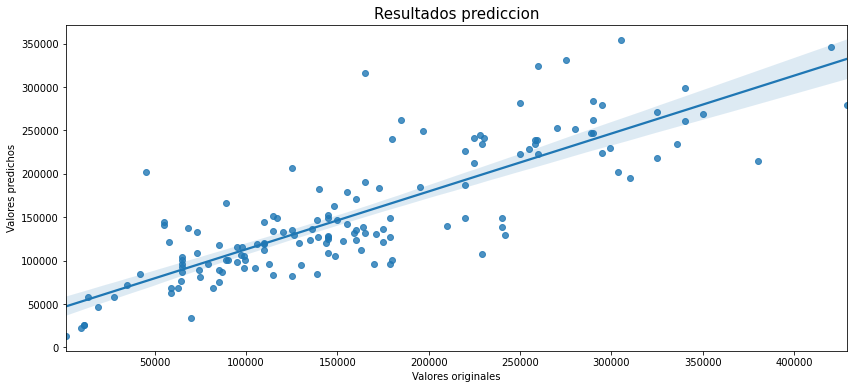

In [ ]:
results_svm_df = pd.DataFrame({"precios":y_test,"predicciones":predictions_SVM})
scatterPlot(results_rf_df,"Resultados prediccion","precios","Valores originales","predicciones","Valores predichos",True)

### XGBoost

In [ ]:
XGB_model = XGBRegressor()

In [ ]:
param_grid = {"XGB__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
              "XGB__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
              "XGB__min_child_weight" : [ 1, 3, 5, 7 ],
              "XGB__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
              "XGB__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
              "XGB__n_estimators": [5,10,20,50,75,100]}

In [ ]:
xgb_grid = RandomizedSearchCV(estimator=XGB_model,param_distributions=param_grid,n_iter=650,cv=5,verbose=2,random_state=42,n_jobs=-1)

In [ ]:
xgb_grid.fit(X_train,y_train)

Fitting 5 folds for each of 650 candidates, totalling 3250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:  2.7min


[19:58:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 3250 out of 3250 | elapsed:  3.3min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                   param_distributions={'XGB__colsample_bytree': [0.3, 0.4, 0.5,
                                                                  0.7],
                                   

In [ ]:
predictions_XGB = xgb_grid.predict(X_test)

In [ ]:
xgb_score = r2_score(y_test, predictions_XGB)
model_result.append(['XGBoost',xgb_score])

print(xgb_score)

0.707625506224085


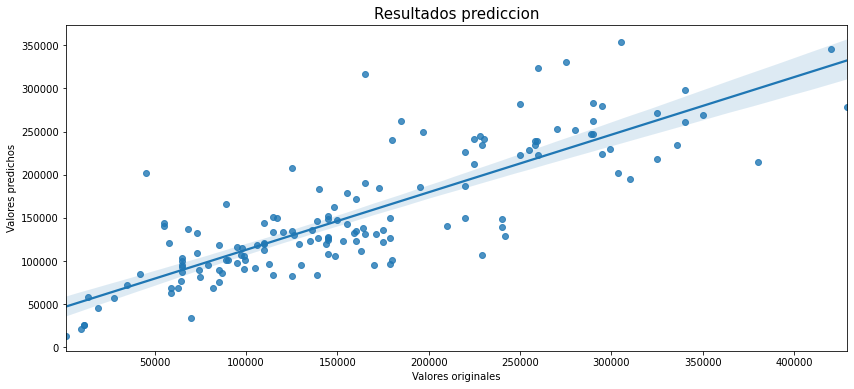

In [ ]:
results_xgb_df = pd.DataFrame({"precios":y_test,"predicciones":predictions_XGB})
scatterPlot(results_rf_df,"Resultados prediccion","precios","Valores originales","predicciones","Valores predichos",True)

### Lasso

In [ ]:
cross_validation = RepeatedKFold(n_splits=5, random_state=1)

In [ ]:
lasso_model = LassoCV(alphas=arange(0, 1, 0.02), cv=cross_validation , n_jobs=-1,tol=0.00001)

In [ ]:
lasso_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23670078212.156067, tolerance: 27829722.62442929
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6434086711.454834, tolerance: 26471994.710320417
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8047455775.135742, tolerance: 27829722.62442929
  tol, rng, random, positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to incr

LassoCV(alphas=array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98]),
        copy_X=True, cv=RepeatedKFold(n_repeats=10, n_splits=5, random_state=1),
        eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=-1,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=1e-05, verbose=False)

In [ ]:
predictions_Lasso = lasso_model.predict(X_test)

In [ ]:
lasso_score = r2_score(y_test, predictions_Lasso)
model_result.append(['Lasso',lasso_score])

print(lasso_score)

0.741031272291447


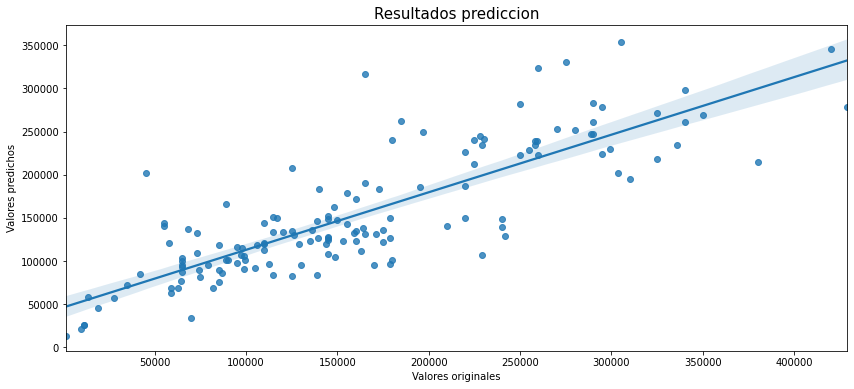

In [ ]:
results_xgb_df = pd.DataFrame({"precios":y_test,"predicciones":predictions_Lasso})
scatterPlot(results_rf_df,"Resultados prediccion","precios","Valores originales","predicciones","Valores predichos",True)

### Ridge

In [ ]:
from sklearn.linear_model import RidgeCV

In [ ]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

In [ ]:
ridge = RidgeCV(alphas=arange(0, 1, 0.01), cv=cv)

In [ ]:
ridge.fit(X_train,y_train)

RidgeCV(alphas=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
        cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=1),
        fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [ ]:
predictions_ridge = ridge.predict(X_test)

In [ ]:
ridge_score = r2_score(y_test, predictions_ridge)
model_result.append(['Ridge',ridge_score])

print(ridge_score)

0.7419325212845354


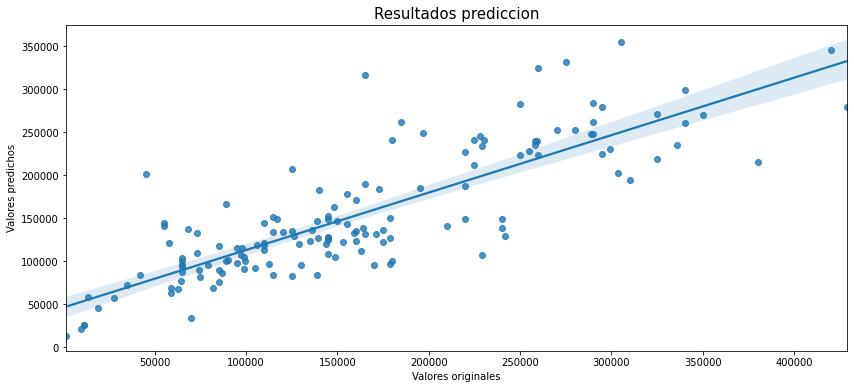

In [ ]:
results_xgb_df = pd.DataFrame({"precios":y_test,"predicciones":predictions_ridge})
scatterPlot(results_rf_df,"Resultados prediccion","precios","Valores originales","predicciones","Valores predichos",True)

# Resultados

In [ ]:
resumen_modelos = pd.DataFrame(model_result,columns=['Modelo','R2_Score'])

In [ ]:
resumen_modelos.sort_values("R2_Score",ascending=False)

,Modelo,R2_Score
4,Ridge,0.741933
3,Lasso,0.741031
1,SVM,0.735298
2,XGBoost,0.707626
0,Random Forest,0.685854


En este caso el modelo que obtuvo mejor R2 Score es Ridge